<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/bathymetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install essential libraries
!pip install plotly geopandas rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 95.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# For XYZ data (tabular format)
bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',
                      delim_whitespace=True,
                      names=['Longitude', 'Latitude', 'Depth'])

# For ASC/Esri ASCII (gridded format)
with open('Apr19_bathy_NAVD88.asc') as f:
    ncols = int(f.readline().split()[1])
    nrows = int(f.readline().split()[1])
    xll = float(f.readline().split()[1])  # xllcorner/center
    yll = float(f.readline().split()[1])  # yllcorner/center
    cellsize = float(f.readline().split()[1])
    nodata = float(f.readline().split()[1])

    data = np.loadtxt(f, dtype=np.float32)

depth_grid = np.flipud(data)  # ASC files are top-to-bottom

<ipython-input-3-c25d3307aaee>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bathy_df = pd.read_csv('/content/Apr19_bathy_NAVD88.xyz',


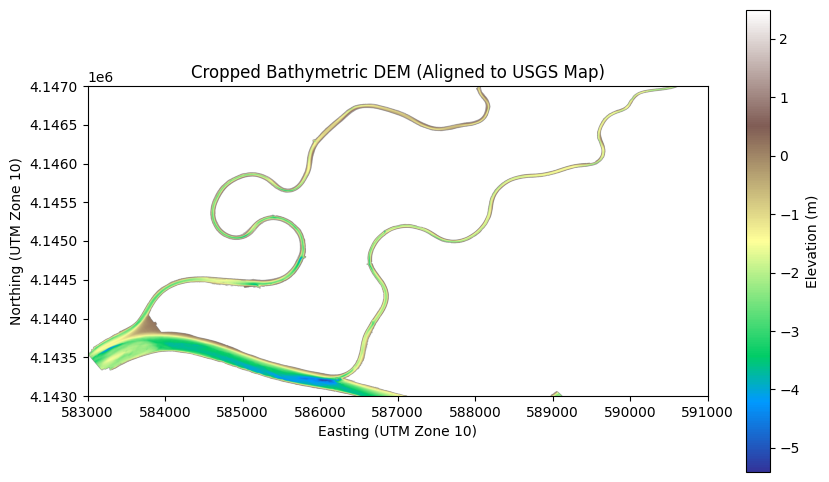

In [12]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])  # Bottom-right corner

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Find index range for cropping
    x_range = (583000, 591000)
    y_range = (4143000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max(), x_indices.min():x_indices.max()]

plt.figure(figsize=(10, 6))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="lower",
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.colorbar(label="Elevation (m)")
plt.title("Cropped Bathymetric DEM (Aligned to USGS Map)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()


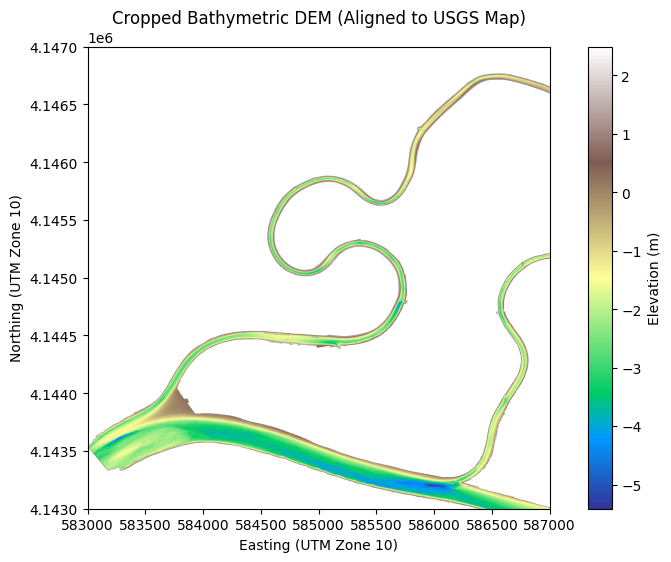

In [20]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File path
asc_file = "/content/Apr19_bathy_NAVD88.asc"

# Load the ASC file
with rasterio.open(asc_file) as dataset:
    array = dataset.read(1)
    nodata = dataset.nodata
    array[array == nodata] = np.nan

    transform = dataset.transform
    x_min, y_max = transform * (0, 0)
    x_max, y_min = transform * (array.shape[1], array.shape[0])  # Bottom-right corner

    # Generate UTM coordinate arrays
    x_coords = np.linspace(x_min, x_max, array.shape[1])
    y_coords = np.linspace(y_max, y_min, array.shape[0])

    # Find index range for cropping
    x_range = (583000, 587000)
    y_range = (4143000, 4147000)

    x_indices = np.where((x_coords >= x_range[0]) & (x_coords <= x_range[1]))[0]
    y_indices = np.where((y_coords >= y_range[0]) & (y_coords <= y_range[1]))[0]

    # Crop array
    cropped_array = array[y_indices.min():y_indices.max(), x_indices.min():x_indices.max()]

plt.figure(figsize=(10, 6))
plt.imshow(cropped_array, cmap="terrain", interpolation="bilinear", origin="lower",
           extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
plt.colorbar(label="Elevation (m)")
plt.title("Cropped Bathymetric DEM (Aligned to USGS Map)")
plt.xlabel("Easting (UTM Zone 10)")
plt.ylabel("Northing (UTM Zone 10)")
plt.show()
